We will now filter and process the participant activity data by ensuring sufficient battery voltage and consistent time intervals, then save the cleaned data for further analysis.

In [3]:
import os
import pandas as pd

# Defining the main directory containing the participant folders
TRAIN_DIR = '/Users/nandana_hemanth/Documents/Semester II/DATA 245/Project/Dataset/child-mind-institute-problematic-internet-use/series_train.parquet'

# Defining the constants
battery_threshold = 3785.08  
expected_interval = 5  

# Defining the Directory to save the cleaned data
CLEANED_DIR = '/Users/nandana_hemanth/Documents/Semester II/DATA 245/Project/Dataset/child-mind-institute-problematic-internet-use/cleaned_series_train.parquet'
os.makedirs(CLEANED_DIR, exist_ok=True)

# Counter to keep track of processed files
processed_files_count = 0

# Iterating over each participant's folder
for folder in os.listdir(TRAIN_DIR):
    participant_path = os.path.join(TRAIN_DIR, folder)
    if os.path.isdir(participant_path):
        # Loading participant's data
        file_path = os.path.join(participant_path, 'part-0.parquet')
        series_data = pd.read_parquet(file_path)

        # Step 1: Filtering by Battery Voltage
        filtered_data = series_data[series_data['battery_voltage'] >= battery_threshold].copy()

        # Step 2: Converting to Continuous Time Scale if needed
        if 'day_time' not in filtered_data.columns:
            filtered_data['time_of_day_hours'] = filtered_data['time_of_day'] / 1e9 / 3600  # Converting to hours
            filtered_data['day_time'] = filtered_data['relative_date_PCIAT'] + (filtered_data['time_of_day_hours'] / 24)

        # Step 3: Calculating Time Differences
        filtered_data['time_diff'] = (filtered_data['day_time'].diff() * 86400).round(0)  # Converting day_time differences to seconds

        # Step 4: Identifying Consistent Blocks (Sessions) After Each Gap
        # Assigning a new session_id each time a gap > 5 seconds is detected
        filtered_data['session_id'] = (filtered_data['time_diff'] > expected_interval).cumsum()

        # Step 5: Keeping Only Consistent Sessions with 5-second intervals
        consistent_data = pd.DataFrame()  # Empty DataFrame to store results
        for session_id, session_data in filtered_data.groupby('session_id'):
            # Checking if all intervals within the session are exactly 5 seconds (ignoring first NaN)
            if (session_data['time_diff'].dropna() == expected_interval).all():
                consistent_data = pd.concat([consistent_data, session_data])  # Keep this session

        # Dropping helper columns if no longer needed
        consistent_data.drop(columns=['time_diff', 'time_of_day_hours', 'session_id'], inplace=True)

        # Saving the filtered data to a new file
        cleaned_file_path = os.path.join(CLEANED_DIR, f'{folder}.parquet')
        consistent_data.to_parquet(cleaned_file_path)
        print(f"Processed and saved cleaned data for participant {folder}")
        
        # Incrementing the processed files counter
        processed_files_count += 1

print(f"Total number of files processed: {processed_files_count}")

Processed and saved cleaned data for participant id=0d01bbf2
Processed and saved cleaned data for participant id=cefdb7fe
Processed and saved cleaned data for participant id=58391429
Processed and saved cleaned data for participant id=2ca2206f
Processed and saved cleaned data for participant id=19455336
Processed and saved cleaned data for participant id=ca33a5e7
Processed and saved cleaned data for participant id=92bb8516
Processed and saved cleaned data for participant id=2812951b
Processed and saved cleaned data for participant id=6b6467f4
Processed and saved cleaned data for participant id=9d6b1410
Processed and saved cleaned data for participant id=22c72c4e
Processed and saved cleaned data for participant id=b3b200af
Processed and saved cleaned data for participant id=ebf30e46
Processed and saved cleaned data for participant id=2a0b8386
Processed and saved cleaned data for participant id=71c1b1d2
Processed and saved cleaned data for participant id=e683d2c9
Processed and saved clea

Validating the cleaned activity data by checking for consistent time intervals, sufficient battery voltage, and non-empty files and reporting any issues if encountered.

In [5]:
import os
import pandas as pd

# Defining the directory containing the cleaned data
CLEANED_DIR = '/Users/nandana_hemanth/Documents/Semester II/DATA 245/Project/Dataset/child-mind-institute-problematic-internet-use/cleaned_series_train.parquet'
battery_threshold = 3785.08  
expected_interval = 5  

# Initializing counters
total_files = 0
files_with_issues = 0

# Iterating over each cleaned file to validate the filtering operation performed above
for file in os.listdir(CLEANED_DIR):
    file_path = os.path.join(CLEANED_DIR, file)
    cleaned_data = pd.read_parquet(file_path)
    
    # Incrementing the file counter
    total_files += 1
    
    # Validation 1: Checking for consistent time intervals
    cleaned_data['time_diff'] = (cleaned_data['day_time'].diff() * 86400).round(0)  # Converting day_time differences to seconds
    if not (cleaned_data['time_diff'].dropna() == expected_interval).all():
        print(f"Inconsistent intervals in file: {file}")
        files_with_issues += 1

    # Validation 2: Verifying the battery levels
    if (cleaned_data['battery_voltage'] < battery_threshold).any():
        print(f"Entries below battery threshold in file: {file}")
        files_with_issues += 1

    # Validation 3: Checking if the file is empty
    if cleaned_data.empty:
        print(f"File {file} is empty after cleaning.")
        files_with_issues += 1

print(f"Total files processed: {total_files}")
print(f"Total files with issues: {files_with_issues}")
if files_with_issues == 0:
    print("All files passed the validation checks.")
else:
    print(f"Some files had issues. Check the log above for details.")

Total files processed: 996
Total files with issues: 0
All files passed the validation checks.


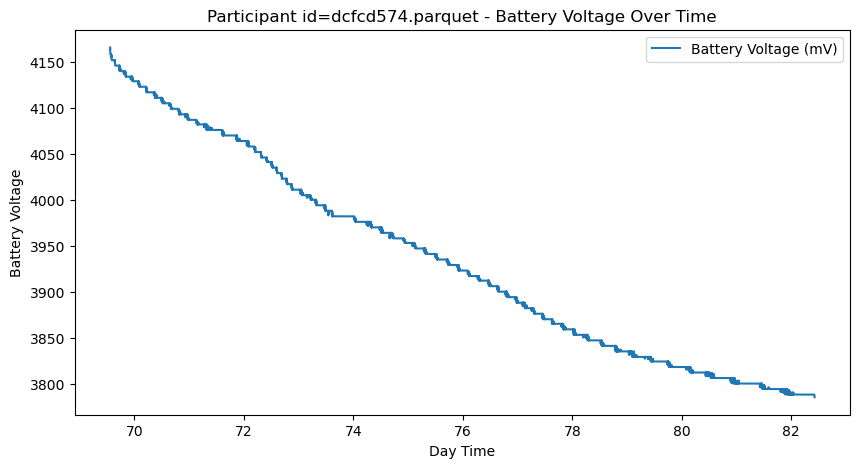

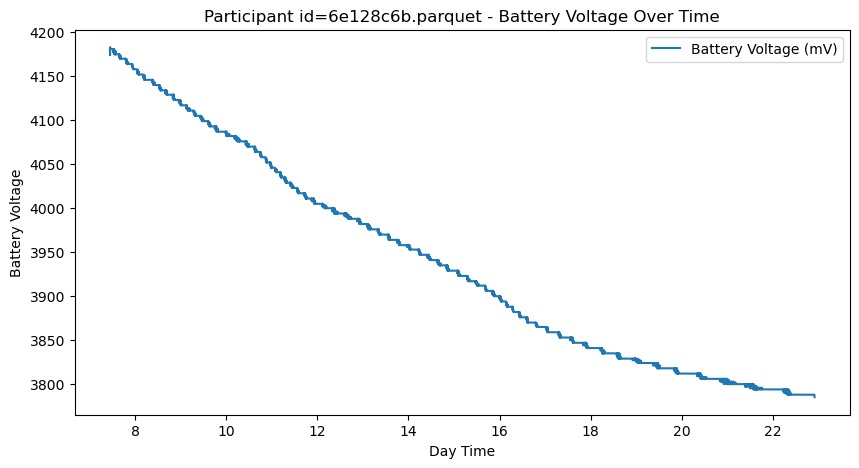

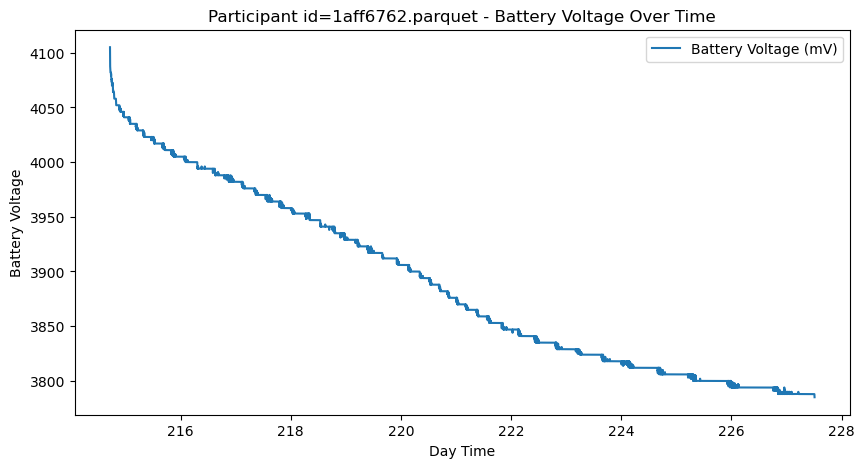

In [7]:
import matplotlib.pyplot as plt
import random

# Randomly sampling a few files for visual inspection
sample_files = random.sample(os.listdir(CLEANED_DIR), 3)  

for file in sample_files:
    file_path = os.path.join(CLEANED_DIR, file)
    cleaned_data = pd.read_parquet(file_path)

    # Plotting battery voltage over time
    plt.figure(figsize=(10, 5))
    plt.plot(cleaned_data['day_time'], cleaned_data['battery_voltage'], label='Battery Voltage (mV)')
    plt.xlabel('Day Time')
    plt.ylabel('Battery Voltage')
    plt.title(f"Participant {file} - Battery Voltage Over Time")
    plt.legend()
    plt.show()

The cleaning process has been successfully completed.